# Digit Recognizer Kaggle Challenge on MNIST Dataset

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(2)
%matplotlib inline

In [221]:
train = pd.read_csv('data/train.csv')
X_test = pd.read_csv('data/test.csv')

## EDA

In [222]:
print('Shape of training data: ', train.shape)
print('Shape of testing data: ', X_test.shape)

Shape of training data:  (42000, 785)
Shape of testing data:  (28000, 784)


In [223]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [224]:
X_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [225]:
missing_values_train = np.sum(train.isna().sum())
missing_values_test = np.sum(X_test.isna().sum())

print(f'There are {missing_values_train} missing values in the training set.')
print(f'There are {missing_values_test} missing values in the testing set.')

There are 0 missing values in the training set.
There are 0 missing values in the testing set.


In [226]:
X_train = train.drop('label', axis=1)
y_train = train['label']

In [227]:
print('Shape of training data: ', X_train.shape)

Shape of training data:  (42000, 784)


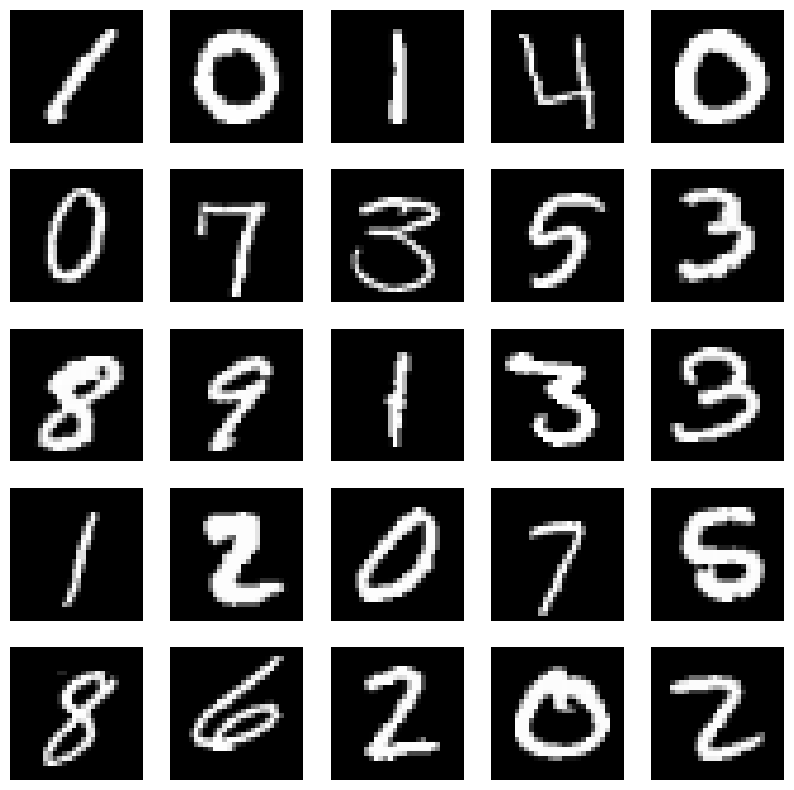

In [228]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train.iloc[i].values.reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.show()

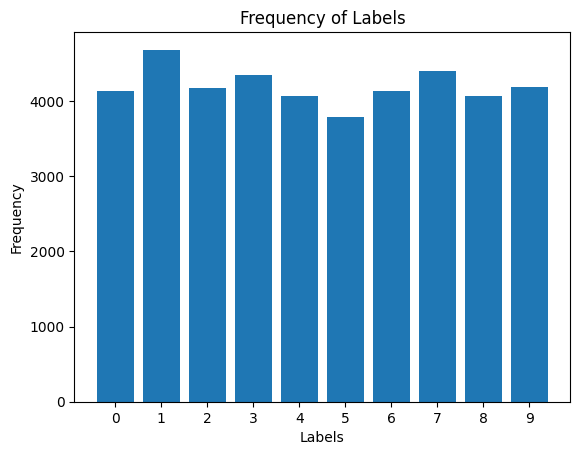

In [229]:
unique_labels, counts = np.unique(y_train, return_counts=True)

plt.bar(unique_labels, counts)

plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Labels')

plt.xticks(unique_labels)

plt.show()

## Feature Engineering

In [230]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [231]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

In [232]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
y_train = y_train.values.reshape(-1, 1)
y_train = encoder.fit_transform(y_train)

In [233]:
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)

Shape of X_train: (42000, 28, 28, 1)
Shape of X_test: (28000, 28, 28, 1)
Shape of y_train: (42000, 10)


## Data Splitting

In [234]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

In [235]:
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)

Shape of X_train: (37800, 28, 28, 1)
Shape of X_val: (4200, 28, 28, 1)


## Data Augmentation

In [236]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [237]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

In [238]:
datagen.fit(X_train)